### Atividade -- Data Augmentation

Aluno: Lucas Elias de Andrade Cruvinel

Matricula: 20232011270241

Modelos Utilizados: Rotation e Flips

In [1]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# from keras.applications.vgg16 import VGG16, preprocess_input
# 

In [2]:
def get_data_path():
    
    with open(r"visaoAugmentation/bd/meta/train.txt", "r") as f:
        name, tipo, classe = [], [], []
        for aux in f.readlines():
            name.append(f"visaoAugmentation/bd/images/{aux[:-1]}.jpg")
            tipo.append("train")
            classe.append(aux.split("/")[0])
        train_data = pd.DataFrame({
            "path":name, 
            "type":tipo, 
            "class":classe
        })
    with open(r"visaoAugmentation/bd/meta/test.txt", "r") as f:
        name, tipo, classe = [], [], []
        for aux in f.readlines():
            name.append(f"visaoAugmentation/bd/images/{aux[:-1]}.jpg")
            tipo.append("test")
            classe.append(aux.split("/")[0])
        test_data = pd.DataFrame({
            "path":name, 
            "type":tipo, 
            "class":classe
        })

    return train_data, test_data

train_data, test_data = get_data_path()

In [3]:
unique_classes = train_data['class'].unique()[:10]
print(unique_classes)
train_data = train_data[train_data['class'].isin(unique_classes)]
test_data = test_data[test_data['class'].isin(unique_classes)]

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito']


In [4]:
train_data

,path,type,class
0,visaoAugmentation/bd/images/apple_pie/1005649.jpg,train,apple_pie
1,visaoAugmentation/bd/images/apple_pie/1014775.jpg,train,apple_pie
2,visaoAugmentation/bd/images/apple_pie/1026328.jpg,train,apple_pie
3,visaoAugmentation/bd/images/apple_pie/1028787.jpg,train,apple_pie
4,visaoAugmentation/bd/images/apple_pie/1043283.jpg,train,apple_pie
...,...,...,...
7495,visaoAugmentation/bd/images/breakfast_burrito/...,train,breakfast_burrito
7496,visaoAugmentation/bd/images/breakfast_burrito/...,train,breakfast_burrito
7497,visaoAugmentation/bd/images/breakfast_burrito/...,train,breakfast_burrito
7498,visaoAugmentation/bd/images/breakfast_burrito/...,train,breakfast_burrito


In [5]:
test_data

,path,type,class
0,visaoAugmentation/bd/images/apple_pie/1011328.jpg,test,apple_pie
1,visaoAugmentation/bd/images/apple_pie/101251.jpg,test,apple_pie
2,visaoAugmentation/bd/images/apple_pie/1034399.jpg,test,apple_pie
3,visaoAugmentation/bd/images/apple_pie/103801.jpg,test,apple_pie
4,visaoAugmentation/bd/images/apple_pie/1038694.jpg,test,apple_pie
...,...,...,...
2495,visaoAugmentation/bd/images/breakfast_burrito/...,test,breakfast_burrito
2496,visaoAugmentation/bd/images/breakfast_burrito/...,test,breakfast_burrito
2497,visaoAugmentation/bd/images/breakfast_burrito/...,test,breakfast_burrito
2498,visaoAugmentation/bd/images/breakfast_burrito/...,test,breakfast_burrito


In [6]:
def create_data_generators(train_generator, batch_size, dataframe):
    training = train_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col="path",
        y_col="class",
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
        )

    validation = train_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col="path",
        y_col="class",
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
        )
    return training, validation

testgen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
    dataframe=test_data,
    x_col="path",
    y_col="class",
    target_size=(128, 128),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
    )

Found 2500 validated image filenames.


In [7]:
def create_prof_model(class_subset):
    model = Sequential()

    #### Input Layer ####
    model.add(InputLayer(shape=(128, 128, 3)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

    #### Convolutional Layers ####
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))  # Pooling
    model.add(Dropout(0.2)) # Dropout

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
    model.add(Conv2D(512, (5,5), activation='relu'))
    model.add(MaxPooling2D((4,4)))
    model.add(Dropout(0.2))

    #### Fully-Connected Layer ####
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(class_subset), activation='softmax'))

    return model
    
model = create_prof_model(unique_classes)
model.summary() # a handy way to inspect the architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 512)    │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 512)    │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,588,458 (40.39 MB)

 Trainable params: 10,588,458 (40.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def run_model(train_data, idg, batch_size, n_epochs, optimizer, checkpoint_filepath):
    training, validation = create_data_generators(idg, batch_size, train_data)
    
    steps_per_epoch = training.samples // batch_size
    val_steps = validation.samples // batch_size

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Saves Keras model after each epoch
    checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,
                                verbose=1,
                                save_best_only=True)

    # Early stopping to prevent overtraining and to ensure decreasing validation loss
    early_stop = EarlyStopping(monitor='val_loss',
                            patience=10,
                            restore_best_weights=True,
                            mode='min')

    # tensorboard_callback = TensorBoard(log_dir="./logs")

    # Actual fitting of the model
    history = model.fit(training,
                        epochs=n_epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=validation,
                        validation_steps=val_steps,
                        callbacks=[
                            early_stop, 
                            checkpointer, 
                            # PlotLossesKeras()
                            ],
                        verbose=True)
    return history


In [9]:
idgs = {
    "padrao": ImageDataGenerator(rescale=1/255.0, validation_split=0.15),
    "rotation": ImageDataGenerator(rescale=1/255.0, rotation_range=90, validation_split=0.15),
    "flip": ImageDataGenerator(rescale=1/255.0, horizontal_flip=True, vertical_flip=True, validation_split=0.15),
    "all": ImageDataGenerator(rescale=1/255.0, rotation_range=90, horizontal_flip=True, vertical_flip=True, validation_split=0.15),
}

In [10]:
hists = {}
for idg_type in idgs.keys():
    hist = run_model(
        train_data=train_data,
        idg = idgs[idg_type],
        batch_size = 32,
        n_epochs = 60,
        optimizer = RMSprop(learning_rate=0.0001),
        checkpoint_filepath = f"visaoAugmentation/pesos/food_model_{idg_type}.weights.keras"
    )
    break
    hists[idg_type] = hist

Found 6375 validated image filenames belonging to 10 classes.
Found 1125 validated image filenames belonging to 10 classes.
Epoch 1/60


c:\Projetos\coias-aleatorias\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.1433 - loss: 2.1993
Epoch 1: val_loss improved from inf to 4.89793, saving model to visaoAugmentation/pesos/food_model_padrao.weights.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 125s 616ms/step - accuracy: 0.1435 - loss: 2.1990 - val_accuracy: 0.0000e+00 - val_loss: 4.8979
Epoch 2/60
  1/199 ━━━━━━━━━━━━━━━━━━━━ 1:49 553ms/step - accuracy: 0.2812 - loss: 2.1587
Epoch 2: val_loss improved from 4.89793 to 3.63598, saving model to visaoAugmentation/pesos/food_model_padrao.weights.keras


C:\Users\Lucri\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 2.1587 - val_accuracy: 0.0000e+00 - val_loss: 3.6360
Epoch 3/60
163/199 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.2529 - loss: 1.9945

KeyboardInterrupt: 

In [ ]:
indexes = {class_name: i for i, class_name in enumerate(unique_classes)}
y_true = [indexes[elem] for elem in test_data["class"]]
y_preds = {}

for idg_type in idgs.keys():
    model = load_model(f"visaoAugmentation/pesos/food_model_{idg_type}.weights.keras")
    predict = model.predict(testgen)
    y_preds[idg_type] = np.argmax(predict, axis=-1)

  1/750 ━━━━━━━━━━━━━━━━━━━━ 2:33 205ms/step

c:\Projetos\coias-aleatorias\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step


[]

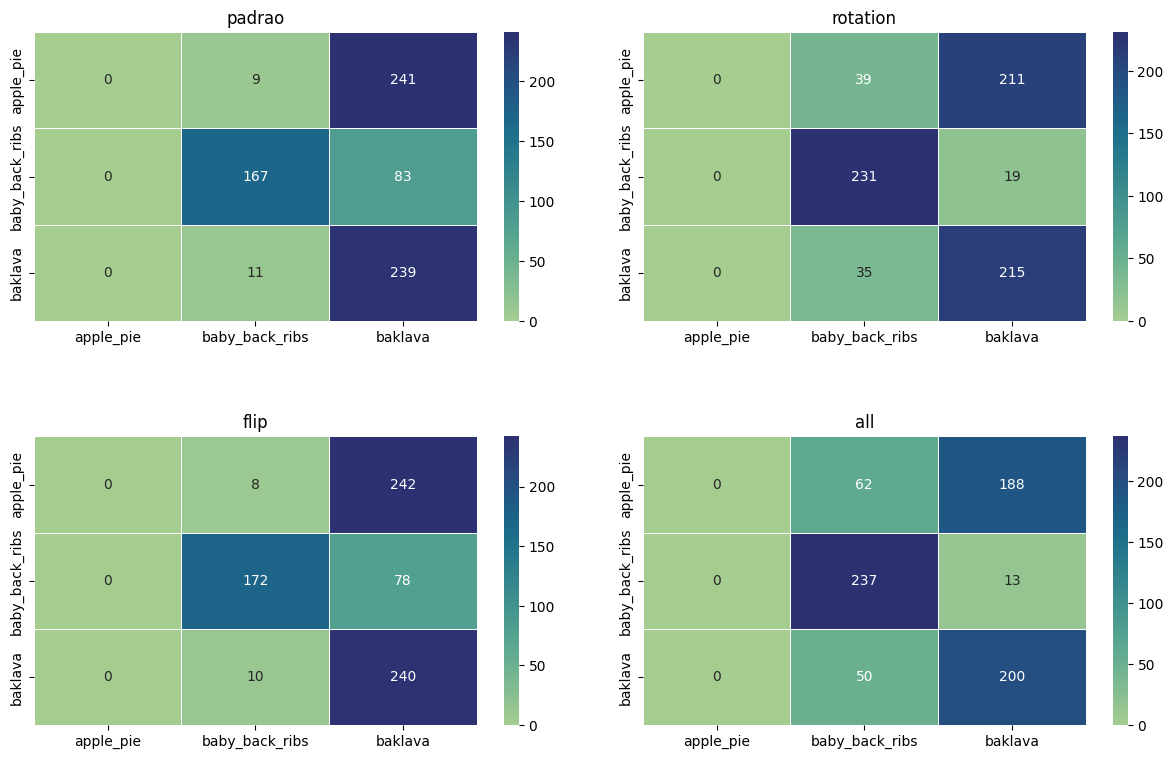

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
suplots = (2, 2)
k = 0
report = {}
for i in range(suplots[0]):
    for j in range(suplots[1]):
        key = list(idgs.keys())[k]
        k +=1
        axes[i, j].set_title(key)
        cm = confusion_matrix(y_true, y_preds[key])
        report[key] = classification_report(y_true, y_preds[key], target_names=unique_classes, output_dict=True, zero_division=0.0)
        sns.heatmap(cm, ax=axes[i, j], annot=True, fmt="d", linewidth=.5, cmap="crest", xticklabels=unique_classes, yticklabels=unique_classes)

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig("confusion_matrix.png")
plt.plot()

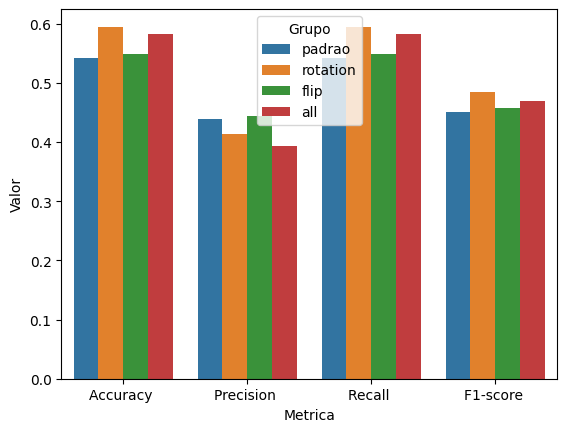

In [ ]:
data = []
for key in report.keys():
    data.append([key, "Accuracy ", report[key]["accuracy"]])
    data.append([key, "Precision ", report[key]["macro avg"]["precision"]])
    data.append([key, "Recall ", report[key]["macro avg"]["recall"]])
    data.append([key, "F1-score ", report[key]["macro avg"]["f1-score"]])

df = pd.DataFrame(data, columns=['Grupo', 'Metrica', 'Valor'])
sns.barplot(data=df, x='Metrica', y='Valor', hue='Grupo')
plt.savefig("barplot.png")
plt.show()